# Updates

In [37]:
# !pip install -U transformers
# !pip install -U accelerate

# Imports

In [38]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from joblib import Parallel, delayed

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.semi_supervised import LabelPropagation, SelfTrainingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from multiprocessing import Pool

In [39]:
TEST_DATA_PATH = "/content/test_imdb.jsonl"
TRAIN_DATA_PATH = "/content/train_imdb.jsonl"
UNLABELLED_DATA_PATH = "/content/aug_imdb_unlabeled.jsonl"
UNLABELLED_DATA_LABELLED_PATH = "/content/unlabelledImdbDf_labelled.csv"

## Loading DataSets

In [40]:
trainImdbDf = pd.read_json(TRAIN_DATA_PATH, lines=True)
testImdbDf = pd.read_json(TEST_DATA_PATH, lines=True)
unlabelledImdbDf = pd.read_json(UNLABELLED_DATA_PATH, lines=True)
unlabelledImdbDf_labelled = pd.read_csv(UNLABELLED_DATA_LABELLED_PATH)

In [41]:
trainImdbDf.head()

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0...."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000..."


By calling the `info()` method, we can see that the dataset contains 3 columns: `text`, `label`, and `encoding`. All entries in all three datasets (train, test, and unlabelled) are non-null, indicating that there are no missing values in the dataset.

In [42]:
trainImdbDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


In [43]:
unlabelledImdbDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1014 non-null   object
 1   embedding  1014 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


In [44]:
testImdbDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


By calling the `describe()` method, we can see the mean value which is for the `label` column. The mean value in both train and test datasets are close to 0.5 (0.55 in train dataset and 0.48 in test dataset), indicating that the labels are relatively balanced in both datasets. This is important for training a model that can generalize well to unseen data.

In [45]:
trainImdbDf.describe()

,label
count,150.000000
mean,0.553333
std,0.498813
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [46]:
testImdbDf.describe()

,label
count,150.000000
mean,0.480000
std,0.501274
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# EDA

## Text Data Analysis

In this part, we preprocess the text data in order to analyze it. At first we use `lower()` to convert all the text to lowercase. Then we use the `re` library to remove any special characters, numbers, and extra spaces from the text. We replace line break tags, HTML tags, and punctuation marks with spaces. We also remove the stop words using `nltk`.

In [47]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<br\s*/><br\s*/>', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[.?,-]', ' ', text)
    return text

In [48]:
def plot_comment_length_distribution(df, df_type):
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    all_words = ' '.join(df['cleaned_text']).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)

    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title('Most Common Words in ' + df_type)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

    wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(df['cleaned_text']))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Comments in ' + df_type)
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


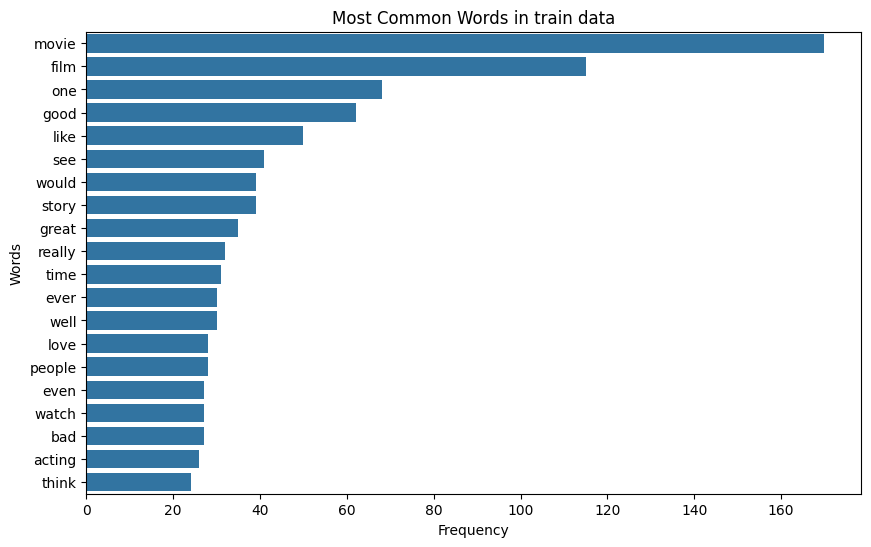

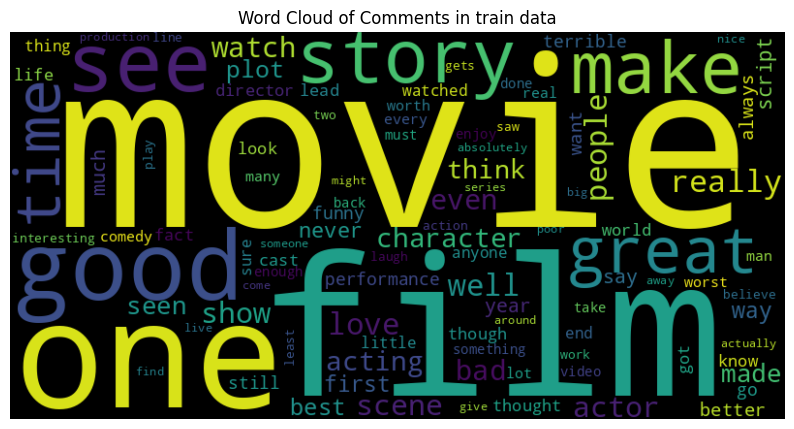

In [49]:
plot_comment_length_distribution(trainImdbDf, "train data")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


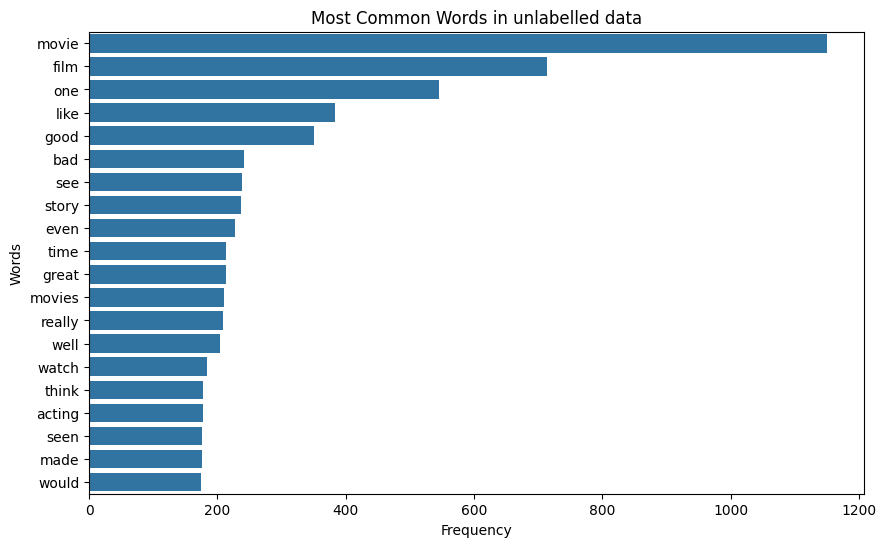

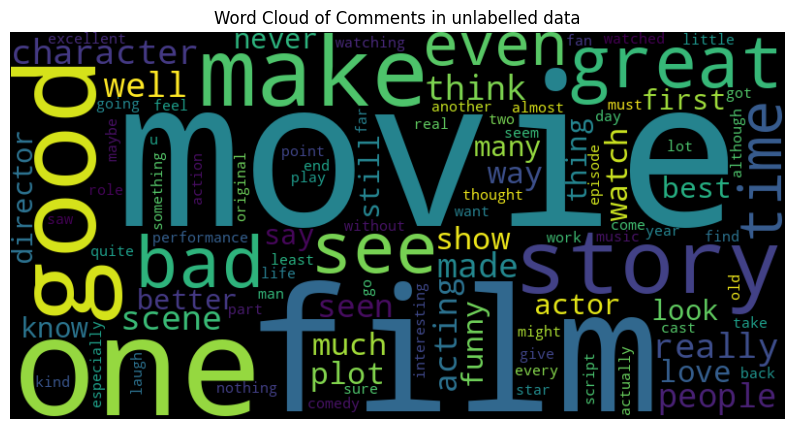

In [50]:
plot_comment_length_distribution(unlabelledImdbDf, "unlabelled data")

As we can see from the above word cloud, the most frequent words in the train and unlabelled datasets are "movie", and "film" as expected.

## Labels' Distribution

As we can see from the below plot, the majority of the labels are 1 in train dataset but the difference is not significant.

In [51]:
def plot_label_distribution(df, df_type):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=df)
    plt.title('Label Distribution in ' + df_type + ' Dataset')
    plt.show()

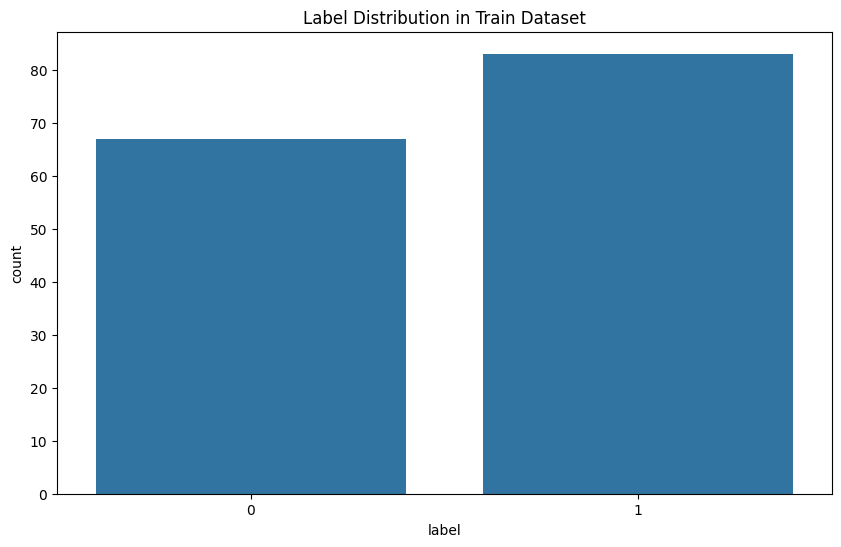

In [52]:
plot_label_distribution(trainImdbDf, 'Train')

In this part , we plot the distribution of labels in the train dataset according to the length of the text. We can see that the label for the texts with length more than 100 is mostly 1, while the label for the texts with length less than 100 is mostly 0. This indicates that the length of the text can be a useful feature for predicting the label.

In [53]:
def plot_label_text_length_distribution(df, df_type):
    df['text_length'] = df['text'].apply(lambda x: len(x.split()))
    palette = {0: 'red', 1: 'green'}
    plt.figure(figsize=(10, 6))
    sns.histplot(df, x='text_length', hue='label', kde=True, palette=palette)
    plt.title('Text Length Distribution in ' + df_type + ' Dataset')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

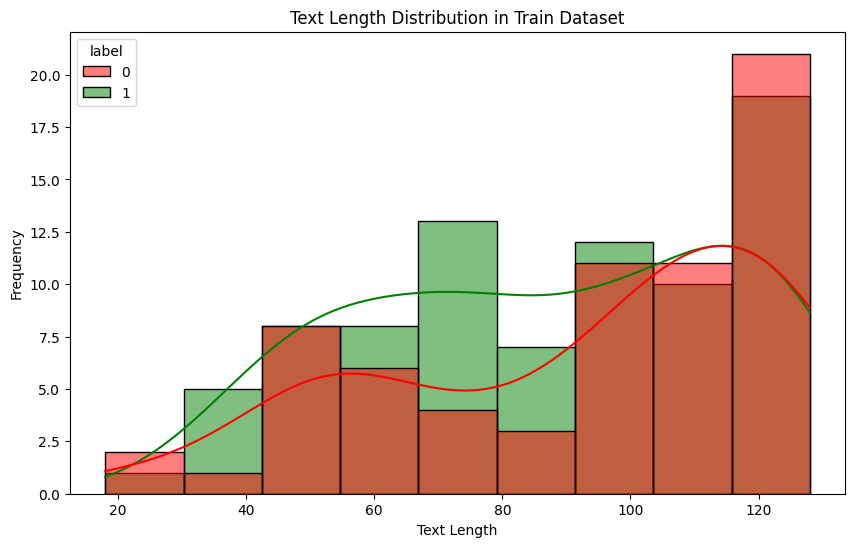

In [54]:
plot_label_text_length_distribution(trainImdbDf, 'Train')

## Embeddings Analysis

The below code performs dimensionality reduction on text embeddings using PCA and t-SNE and then visualizes the PCA results in a 2D scatter plot, with points colored based on their labels (red for "bad" reviews and green for "good" reviews). The dimensionality reduction helps in visualizing the high-dimensional embeddings in a 2D space, making it easier to identify patterns and clusters.

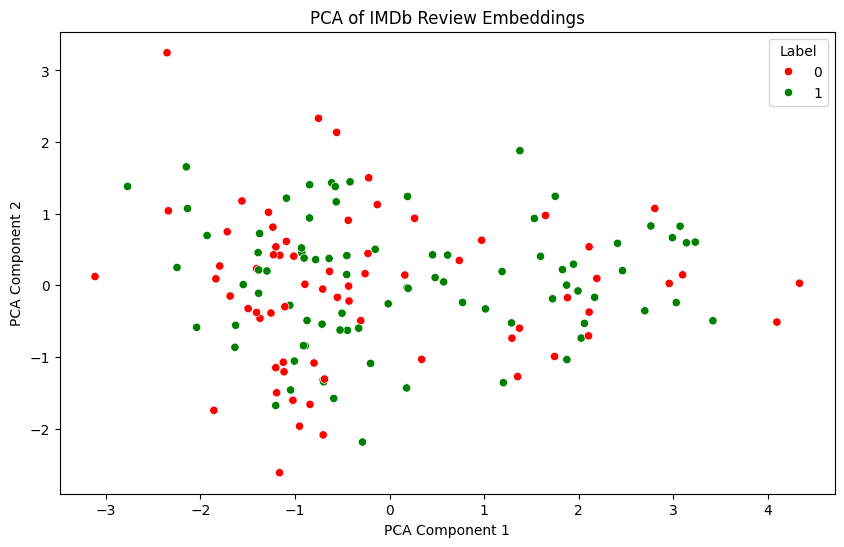

In [55]:
train_embeddings = np.array(trainImdbDf["embedding"].tolist())
pca_eda = PCA(n_components=2)
embeddings_pca = pca_eda.fit_transform(train_embeddings)

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(train_embeddings)

eda_df = trainImdbDf.copy()
eda_df['pca_1'] = embeddings_pca[:, 0]
eda_df['pca_2'] = embeddings_pca[:, 1]
eda_df['tsne_1'] = embeddings_tsne[:, 0]
eda_df['tsne_2'] = embeddings_tsne[:, 1]

palette = {0: "red", 1: "green"}
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=eda_df, palette=palette)
plt.title('PCA of IMDb Review Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Label')
plt.show()

Visualizing the t-SNE-transformed embeddings is done in the below code. t-SNE is a non-linear dimensionality reduction technique that is often used for visualizing high-dimensional data in a lower-dimensional space.

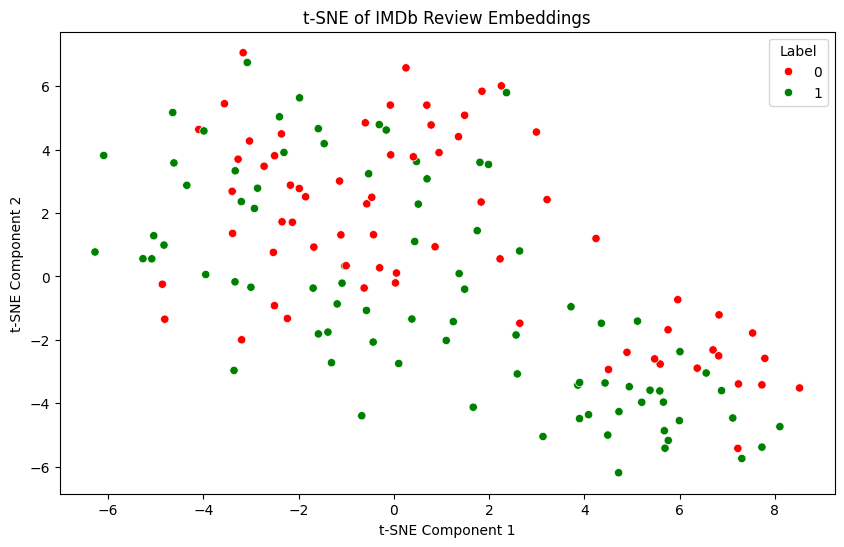

In [56]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=eda_df, palette=palette)
plt.title('t-SNE of IMDb Review Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Label')
plt.show()

As we can see from the scatter plots above, we cannot clearly separate the two classes based on the PCA-transformed embeddings. This indicates that the embeddings might not be linearly separable in the reduced space.

The below provided code creates a series of histograms to visualize the distribution of the first three dimensions of the text embeddings, with each histogram colored by label (good or bad review).

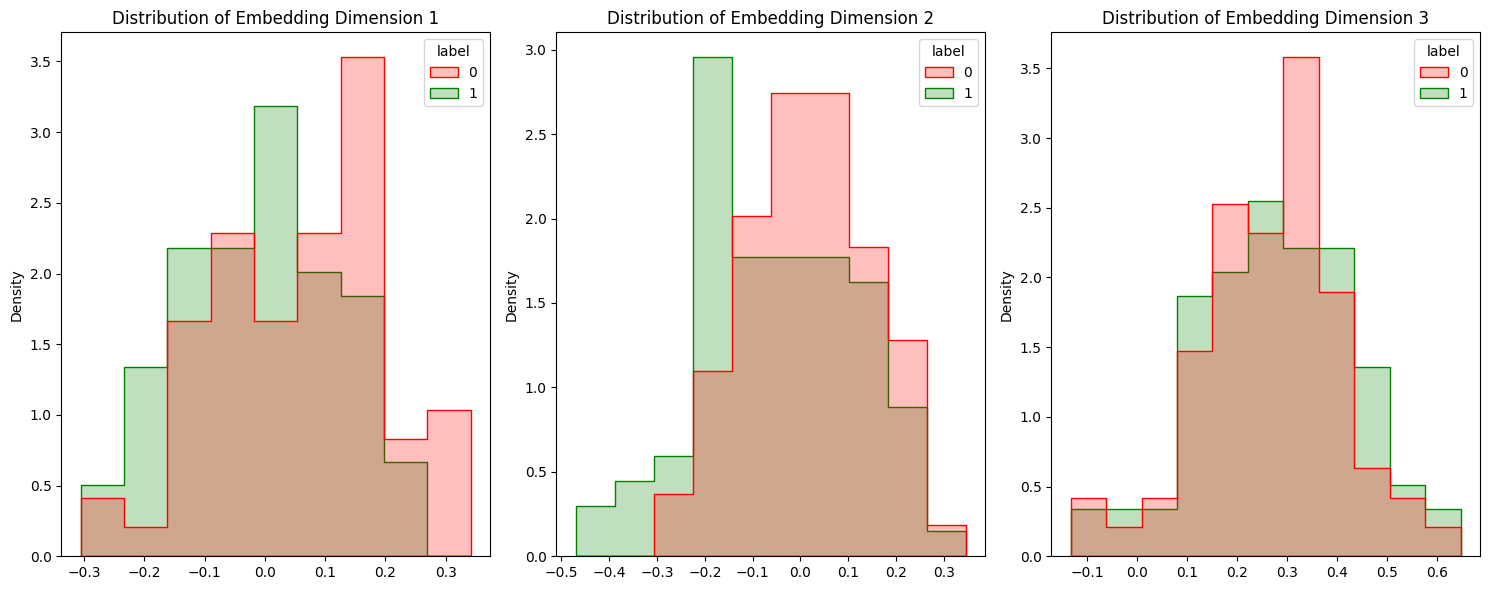

In [57]:
plt.figure(figsize=(15, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.histplot(eda_df, x=train_embeddings[:, i], hue='label', element='step', stat='density', common_norm=False, palette=palette)
    plt.title(f'Distribution of Embedding Dimension {i+1}')
plt.tight_layout()
plt.show()

# Feature Engineering

We already have the text embeddings for the train and test datasets. We can use these embeddings as features to train a machine learning model to predict the labels. In this part we use PCA to reduce the dimensionality of the text embeddings (using 0.95 as the variance threshold).

In [58]:
def add_pca_embeddings(df, pca):
    embeddings = np.array([embedding for embedding in df["embedding"]])
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    embeddings_pca = pca.transform(embeddings)
    df["embedding_pca"] = embeddings_pca.tolist()

In [59]:
unlabelledImdbDf_labelled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          1014 non-null   int64 
 1   text                1014 non-null   object
 2   embedding           1014 non-null   object
 3   label_llm_one_shot  1014 non-null   int64 
 4   embedding_pca       1014 non-null   object
 5   label_llm_few_shot  1014 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 47.7+ KB


In [60]:
pca = PCA(n_components=0.95, random_state=42)
embeddings = np.array([embedding for embedding in trainImdbDf["embedding"]])
embeddings = embeddings.reshape(embeddings.shape[0], -1)
embeddings_pca = pca.fit_transform(embeddings)
n_selected_components = pca.n_components_
print('Number of selected components:', n_selected_components)
trainImdbDf["embedding_pca"] = embeddings_pca.tolist()

add_pca_embeddings(unlabelledImdbDf, pca)
add_pca_embeddings(testImdbDf, pca)

Number of selected components: 90


# Semi-Supervised Learning

## Label Unlabelled Data

In [61]:
def make_dataframe(df, does_use_pca=False):
    if does_use_pca:
        embeddings = np.array([embedding for embedding in df["embedding_pca"]])
    else:
        embeddings = np.array([embedding for embedding in df["embedding"]])
    new_df = pd.DataFrame(embeddings)
    new_df["label"] = df["label"]
    new_df["text"] = df["text"]
    new_df['is_labeled'] = [1 for _ in range(len(new_df))]
    return new_df

trainImdbDf_pca = make_dataframe(trainImdbDf, True)
testImdbDf_pca = make_dataframe(testImdbDf, True)
unlabelled_embeddings = np.array([embedding for embedding in unlabelledImdbDf["embedding"]])
unlabelledImdbDf_pca = pd.DataFrame(unlabelled_embeddings)

trainImdbDf_not_pca = make_dataframe(trainImdbDf, False)
testImdbDf_not_pca = make_dataframe(testImdbDf, False)
unlabelled_embeddings_pca = np.array([embedding for embedding in unlabelledImdbDf["embedding_pca"]])
unlabelledImdbDf_not_pca = pd.DataFrame(unlabelled_embeddings_pca)

In [62]:
def combine_labelled_unlabelled(trainImdbDf, unlabelledImdbDf, does_use_pca):
    if does_use_pca:
        all_embeddings = np.vstack([np.array(trainImdbDf["embedding_pca"].tolist()),
                                    np.array(unlabelledImdbDf["embedding_pca"].tolist())])
    else:
        all_embeddings = np.vstack([np.array(trainImdbDf["embedding"].tolist()),
                                    np.array(unlabelledImdbDf["embedding"].tolist())])
    all_data = pd.DataFrame(all_embeddings)
    all_data['label'] = np.concatenate([trainImdbDf['label'], [-1]*len(unlabelledImdbDf)])
    all_data['is_labeled'] = np.concatenate([np.ones(len(trainImdbDf)), np.zeros(len(unlabelledImdbDf))])
    all_data['text'] = np.concatenate([trainImdbDf['text'], unlabelledImdbDf['text']])
    all_embeddings = np.vstack([np.array(trainImdbDf["embedding_pca"].tolist()),
                            np.array(unlabelledImdbDf["embedding_pca"].tolist())])
    return all_data

combined_pca = combine_labelled_unlabelled(trainImdbDf, unlabelledImdbDf, True)
combined_not_pca = combine_labelled_unlabelled(trainImdbDf, unlabelledImdbDf, False)

In [63]:
def split_X_y(df):
    X = df.drop(columns=["label", "text", "is_labeled"])
    y = df["label"]
    X = X.values
    y = y.values
    return X, y

### KMean Clustering




In this part we use KMeans clustering to label the unlabeled data. At first we get the best number of clusters using the silhouette score. Here the best number of clusters is 2 but if we partition the train data into 2 clusters, the majority of both clusters have label 1 so the label of all unlabelled data will be 1. So we choose the number of clusters to be 6. Then we fit the KMeans model on the train data and predict the labels for the unlabelled data.

In [64]:
def compute_kmeans_silhouette(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    return (n_clusters, kmeans.inertia_, silhouette_avg)

def get_best_num_clusters(n_clusters, data):
    best_n_clusters = 1
    best_silhouette_score = -1
    wcss = []
    silhouette_scores = []
    range_n_clusters = range(2, n_clusters+1)
    results = Parallel(n_jobs=-1)(delayed(compute_kmeans_silhouette)(n_clusters, data) for n_clusters in range_n_clusters)

    for n_clusters, inertia, silhouette_avg in results:
        print(f"Number of clusters: {n_clusters}, WCSS: {inertia}, Silhouette score: {silhouette_avg}")
        wcss.append(inertia)
        silhouette_scores.append(silhouette_avg)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_n_clusters = n_clusters

    print(f"Best number of clusters for KMeans: {best_n_clusters}")

In [65]:
get_best_num_clusters(10, combined_not_pca.iloc[:, :-3])

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Number of clusters: 2, WCSS: 12534.346479240841, Silhouette score: 0.12637893088081417
Number of clusters: 3, WCSS: 11977.840728473555, Silhouette score: 0.07651708233126957
Number of clusters: 4, WCSS: 11514.034956091693, Silhouette score: 0.07221153828088755
Number of clusters: 5, WCSS: 11317.478106447548, Silhouette score: 0.053317320902142216
Number of clusters: 6, WCSS: 11150.622524293069, Silhouette score: 0.05147928776809923
Number of clusters: 7, WCSS: 11025.696065749391, Silhouette score: 0.04273926283670289
Number of clusters: 8, WCSS: 10911.097979374124, Silhouette score: 0.04393486426809063
Number of clusters: 9, WCSS: 10812.667141525759, Silhouette score: 0.03963206183429933
Number of clusters: 10, WCSS: 10717.395753098552, Silhouette score: 0.04008802850876288
Best number of clusters for KMeans: 2


As mentioned before, we cluster the train data into 6 clusters and then use the majority label of each cluster to label the unlabelled data in the same cluster.

In [66]:
def label_unlabelled_kmean(df, num_clusters):
    labelled_df = df.copy()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labelled_df['cluster'] = kmeans.fit_predict(labelled_df.iloc[:, :-3])

    cluster_labels = {}
    for cluster in range(num_clusters):
        labels_in_cluster = labelled_df[(labelled_df['cluster'] == cluster) & (labelled_df['is_labeled'] == 1)]['label']
        if len(labels_in_cluster) > 0:
            most_common_label = labels_in_cluster.mode().iloc[0]
            cluster_labels[cluster] = most_common_label
    labelled_df.loc[labelled_df['is_labeled'] == 0, 'label'] = labelled_df[labelled_df['is_labeled'] == 0]['cluster'].map(cluster_labels)
    labelled_df.drop(columns=['cluster'], inplace = True)
    return labelled_df

combined_not_pca_labelled = label_unlabelled_kmean(combined_not_pca, 6)
combined_pca_labelled = label_unlabelled_kmean(combined_pca, 6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Self-Training Using SVC

Self-training is a semi-supervised learning approach where a model is trained iteratively, using its own predictions to label unlabeled data. Here we use Self-training with Support Vector Classifier (SVC) to classify the data. SVC is a supervised learning model that uses labeled data to learn the decision boundary between classes. Self-training with SVC is a simple and effective approach to semi-supervised learning. In a high-dimensional space, SVC aims to find a hyperplane that best separates the data points of different classes. For two-dimensional data, this is a line; for three-dimensional data, it is a plane; and so on. The support vectors are the data points that are closest to the hyperplane. They are crucial because they determine the position and orientation of the hyperplane. The SVC algorithm selects the hyperplane that maximizes the margin between the support vectors of the two classes. The  margin is the distance between the hyperplane and the nearest data point of each class. SVC maximizes this margin to ensure that the classifier generalizes well to unseen data.

In [67]:
trainImdbDf_embeddings_no_pca = np.array(trainImdbDf["embedding"].tolist())
testImdbDf_embeddings_no_pca = np.array(testImdbDf["embedding"].tolist())
unlabelledImdbDf_embeddings_no_pca = np.array(unlabelledImdbDf["embedding"].tolist())
all_embeddings_no_pca = np.vstack([trainImdbDf_embeddings_no_pca, unlabelledImdbDf_embeddings_no_pca])

trainImdbDf_embeddings_pca = np.array(trainImdbDf["embedding_pca"].tolist())
testImdbDf_embeddings_pca = np.array(testImdbDf["embedding_pca"].tolist())
unlabelledImdbDf_embeddings_pca = np.array(unlabelledImdbDf["embedding_pca"].tolist())
all_embeddings_pca = np.vstack([trainImdbDf_embeddings_pca, unlabelledImdbDf_embeddings_pca])

all_labels = np.concatenate([trainImdbDf['label'], [-1]*len(unlabelledImdbDf)])

In [68]:
SELF_TRAINING_THRESHOLD = 0.9

svc = SVC(probability=True, random_state=42)
svc_self_training = SelfTrainingClassifier(svc, criterion='threshold', threshold=SELF_TRAINING_THRESHOLD)
svc_self_training.fit(all_embeddings_no_pca, all_labels)
svc_self_training_pred = svc_self_training.predict(unlabelledImdbDf_embeddings_no_pca)
unlabelledImdbDf_not_pca['label_self_training'] = svc_self_training_pred
all_labels_self_training_not_pca = np.concatenate([trainImdbDf['label'], unlabelledImdbDf_not_pca['label_self_training']])

svc_self_training.fit(all_embeddings_pca, all_labels)
svc_self_training_pred_pca = svc_self_training.predict(unlabelledImdbDf_embeddings_pca)
unlabelledImdbDf_pca['label_self_training'] = svc_self_training_pred_pca
all_labels_self_training_pca = np.concatenate([trainImdbDf['label'], unlabelledImdbDf_pca['label_self_training']])

### Graph Based Label Propagation

Label Propagation is an algorithm used for semi-supervised learning, particularly in the context of classification problems. It belongs to a class of algorithms known as graph-based learning algorithms, which use the structure of a graph to propagate labels from a small set of labeled nodes to a larger set of unlabeled nodes. Labels are propagated through the graph from labeled nodes to their neighboring unlabeled nodes based on the edge weights (similarities). The process iterates, updating the labels of nodes based on their neighbors until convergence or a maximum number of iterations is reached.

In [69]:
graph_label_propagation = LabelPropagation()
graph_label_propagation.fit(all_embeddings_pca, all_labels)
unlabelledImdbDf_pca['label_graph'] = graph_label_propagation.transduction_[len(trainImdbDf):]
all_labels_garph_pca = np.concatenate([trainImdbDf['label'], unlabelledImdbDf_pca['label_graph']])

graph_label_propagation.fit(all_embeddings_no_pca, all_labels)
unlabelledImdbDf_not_pca['label_graph'] = graph_label_propagation.transduction_[len(trainImdbDf):]
all_labels_garph_not_pca = np.concatenate([trainImdbDf['label'], unlabelledImdbDf_not_pca['label_graph']])

### LLM

In this part we use the Phi3 model to label unlabelled data.

In [ ]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def load_model(model_args):
    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )
    return model, tokenizer

In [ ]:
model , tokenizer = load_model(MODEL_ARGS)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def generate_text(model, tokenizer, examples, text, max_new_tokens = 100, do_sample=True, temperature=0.5):
    instruction = "Decide whether the sentiment of the given film review is Positive or Negative. You should write 'Positive' or 'Negative' for each text without any explanations"
    prompt = f"{instruction}\n\n{examples}\n\nReview: {text}\nSentiment:"
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    if do_sample:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
    else:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=do_sample)

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text[len(prompt):]

If the sentiment includes `positive` word, we label it as 1; If it includes `negative` word, we label it as 0 and otherwise we label it as -1. Later we only use the rows with 0 and 1 labels to the final training model.

In [ ]:
import tqdm

def predict_labels_llm(examples, df):
    y_pred = []
    for data in tqdm.tqdm(df['text']):
        label = generate_text(model, tokenizer, examples, data, max_new_tokens=20, do_sample=False, temperature=1.2)
        if "positive" in label.lower():
            y_pred.append(1)
        elif "negative" in label.lower():
            y_pred.append(0)
        else:
            y_pred.append(-1)
    return y_pred

In [ ]:
def print_first_20_result(df, y_pred):
    for i in range(20):
        print("text: ", df['text'].iloc[i])
        print("label: ", y_pred[i])
        print("True label: ", df['label'].iloc[i])
        print("____________________________________________________________")

We use the first 50 rows of our train dataset to check if the LLM model works good or not. As we can see from the results, using one positive and one negative review in the prompt, we get 90% accuracy for the first 50 rows of the train dataset.

In [ ]:
one_shot_example = """
Review: The movie was great. I loved the acting and the plot was amazing.
Sentiment: Positive

Review: The movie was terrible. The acting was bad and the plot was boring.
Sentiment: Negative
"""

trainImdbDf_first_20 = trainImdbDf.iloc[:50]
y_train_pred_llm_one_shot = predict_labels_llm(one_shot_example, trainImdbDf_first_20)
print_first_20_result(trainImdbDf_first_20, y_train_pred_llm_one_shot)
print("Accuracy Score: ", accuracy_score(trainImdbDf_first_20['label'], y_train_pred_llm_one_shot))

text:  fairly good romantic comedy in which i don't think i've ever seen meg looking any cuter. all the players did a good job at keeping this a lively romp. of course, in the real world no genius mathematician would even glance at some grease monkey, but that is why i love romantic comedies....one can just totally forget reality and have a good time. nice film. damn, meg is a babe, eh?
label:  1
True label:  1
____________________________________________________________
text:  "dressed to kill", is one of the best thrillers ever made. its dealings with sex and violence make this a film for adults. brian de palma, once again, proves why no other director can match his use of the camera to tell a story. he directs many scenes without dialog, and he tells much of his story, strictly through the use of his visuals, and pino donnagio's brilliant score. filmed in panavision, the film must be seen in widescreen, as de palma uses the entire width of the film to tell his story. cropped, on vid

As we can see below, using 3 positive and 3 negative reviews in the prompt, we got 88% accuracy in the first 50 records of our train dataset.

In [ ]:
few_shot_example = """
Review: The movie was great. I loved the acting and the plot was amazing.
Sentiment: Positive

Review: The movie was terrible. The acting was bad and the plot was boring.
Sentiment: Negative

Review: I enjoyed every minute of the film. The performances were outstanding and the story was captivating.
Sentiment: Positive

Review: This film was a waste of time. The script was poorly written and the direction was lackluster.
Sentiment: Negative

Review: The visuals were stunning and the music was very moving. It was an unforgettable experience.
Sentiment: Positive

Review: The movie was a huge disappointment. The characters were flat and the pacing was slow.
Sentiment: Negative
"""

y_train_pred_llm_few_shot = predict_labels_llm(few_shot_example, trainImdbDf_first_20)
print_first_20_result(trainImdbDf_first_20, y_train_pred_llm_few_shot)
print("Accuracy Score: ", accuracy_score(trainImdbDf_first_20['label'], y_train_pred_llm_few_shot))

text:  fairly good romantic comedy in which i don't think i've ever seen meg looking any cuter. all the players did a good job at keeping this a lively romp. of course, in the real world no genius mathematician would even glance at some grease monkey, but that is why i love romantic comedies....one can just totally forget reality and have a good time. nice film. damn, meg is a babe, eh?
label:  1
True label:  1
____________________________________________________________
text:  "dressed to kill", is one of the best thrillers ever made. its dealings with sex and violence make this a film for adults. brian de palma, once again, proves why no other director can match his use of the camera to tell a story. he directs many scenes without dialog, and he tells much of his story, strictly through the use of his visuals, and pino donnagio's brilliant score. filmed in panavision, the film must be seen in widescreen, as de palma uses the entire width of the film to tell his story. cropped, on vid

In [ ]:
# y_pred_llm_one_shot = predict_labels_llm(one_shot_example, unlabelledImdbDf)

100%|██████████| 1014/1014 [37:41<00:00,  2.23s/it]


In [ ]:
# unlabelledImdbDf["label_llm_one_shot"] = y_pred_llm_one_shot
# all_labels_llm_one_shot = np.concatenate([trainImdbDf['label'], unlabelledImdbDf["label_llm_one_shot"]])

In [ ]:
# y_pred_llm_few_shot = predict_labels_llm(few_shot_example, unlabelledImdbDf)
# unlabelledImdbDf["label_llm_few_shot"] = y_pred_llm_few_shot
# all_labels_llm_few_shot = np.concatenate([trainImdbDf['label'], unlabelledImdbDf["label_llm_few_shot"]])

100%|██████████| 1014/1014 [43:33<00:00,  2.58s/it]


In [70]:
unlabelledImdbDf_labelled["embedding_pca"] = unlabelledImdbDf_labelled["embedding_pca"].apply(lambda x: eval(x))
unlabelledImdbDf_labelled["embedding"] = unlabelledImdbDf_labelled["embedding"].apply(lambda x: eval(x))

In [71]:
labelled_one_shot = unlabelledImdbDf_labelled[unlabelledImdbDf_labelled["label_llm_one_shot"] != -1]

all_embeddings_one_shot_pca = np.vstack([np.array(trainImdbDf["embedding_pca"].tolist()),
                                    np.array(labelled_one_shot["embedding_pca"].tolist())])
all_embeddings_one_shot_not_pca = np.vstack([np.array(trainImdbDf["embedding"].tolist()),
                                    np.array(labelled_one_shot["embedding"].tolist())])

labelled_few_shot = unlabelledImdbDf_labelled[unlabelledImdbDf_labelled["label_llm_few_shot"] != -1]
all_embeddings_few_shot_pca = np.vstack([np.array(trainImdbDf["embedding_pca"].tolist()),
                                    np.array(labelled_few_shot["embedding_pca"].tolist())])
all_embeddings_few_shot_not_pca = np.vstack([np.array(trainImdbDf["embedding"].tolist()),
                                     np.array(labelled_few_shot["embedding"].tolist())])

all_labels_one_shot = np.concatenate([trainImdbDf['label'], labelled_one_shot['label_llm_one_shot']])
all_labels_few_shot = np.concatenate([trainImdbDf['label'], labelled_few_shot['label_llm_few_shot']])

Here we can see the number of records which has label 0 or 1 using one shot and few shot.

In [73]:
print("Number of labelled using one shot: ", len(labelled_one_shot))
print("Number of labelled using few shot: ", len(labelled_few_shot))

Number of labelled using one shot:  981
Number of labelled using few shot:  894


## Training

We use different models to train the data and predict the labels for the test data. We use Logistic Regression, Random Forest, and Neural Network models. We use the text embeddings as features and the labels as the target variable.

In [74]:
X_train_no_pca, y_train_no_pca = split_X_y(trainImdbDf_not_pca)
X_train_pca , y_train_pca = split_X_y(trainImdbDf_pca)

X_test_no_pca, y_test_no_pca = split_X_y(testImdbDf_not_pca)
X_test_pca, y_test_pca = split_X_y(testImdbDf_pca)

X_combined_not_pca_labelled, y_combined_not_pca_labelled = split_X_y(combined_not_pca_labelled)
X_combined_pca_labelled, y_combined_pca_labelled = split_X_y(combined_pca_labelled)

In [75]:
def predict_labels(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

### Logistic Regression

In [76]:
logisticRegression_model = LogisticRegression(random_state=42, max_iter=1000)
predict_labels(X_train_pca, y_train_pca, X_test_pca, y_test_pca, logisticRegression_model)

Accuracy: 0.7933333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80        78
           1       0.77      0.81      0.79        72

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150



In [77]:
predict_labels(all_embeddings_pca, y_combined_pca_labelled, X_test_pca, y_test_pca, logisticRegression_model)

Accuracy: 0.6
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.74      0.66        78
           1       0.62      0.44      0.52        72

    accuracy                           0.60       150
   macro avg       0.60      0.59      0.59       150
weighted avg       0.60      0.60      0.59       150



In [78]:
predict_labels(all_embeddings_pca, all_labels_self_training_pca, testImdbDf_embeddings_pca, testImdbDf['label'], logisticRegression_model)

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79        78
           1       0.77      0.78      0.77        72

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150



In [79]:
predict_labels(all_embeddings_pca, all_labels_garph_pca, testImdbDf_embeddings_pca, testImdbDf['label'], logisticRegression_model)

Accuracy: 0.7466666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        78
           1       0.74      0.74      0.74        72

    accuracy                           0.75       150
   macro avg       0.75      0.75      0.75       150
weighted avg       0.75      0.75      0.75       150



In [80]:
predict_labels(all_embeddings_one_shot_pca, all_labels_one_shot, testImdbDf_embeddings_pca, testImdbDf['label'], logisticRegression_model)

Accuracy: 0.8533333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        78
           1       0.89      0.79      0.84        72

    accuracy                           0.85       150
   macro avg       0.86      0.85      0.85       150
weighted avg       0.86      0.85      0.85       150



In [81]:
predict_labels(all_embeddings_few_shot_pca, all_labels_few_shot, testImdbDf_embeddings_pca, testImdbDf['label'], logisticRegression_model)

Accuracy: 0.8466666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        78
           1       0.87      0.81      0.83        72

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150



As we can see the Logistic Regression model has the highest accuracy above traditional labeling methods when using the train data and the unlabelled data labelled by self-training with SVC. This model has the lowest accuracy when using the train data and the unlabelled data labelled by KMeans clustering. This indicates that self-training with SVC is more effective in labelling the unlabelled data compared to KMeans clustering.  

### Random Forest

In [82]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
predict_labels(X_train_pca, y_train_pca, X_test_pca, y_test_pca, rf_model)


Accuracy: 0.7133333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.63      0.70        78
           1       0.67      0.81      0.73        72

    accuracy                           0.71       150
   macro avg       0.72      0.72      0.71       150
weighted avg       0.72      0.71      0.71       150



In [83]:
predict_labels(X_combined_pca_labelled, y_combined_pca_labelled, X_test_pca, y_test_pca, rf_model)

Accuracy: 0.56
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.73      0.63        78
           1       0.56      0.38      0.45        72

    accuracy                           0.56       150
   macro avg       0.56      0.55      0.54       150
weighted avg       0.56      0.56      0.55       150



In [84]:
predict_labels(all_embeddings_pca, all_labels_self_training_pca, testImdbDf_embeddings_pca, testImdbDf['label'], rf_model)

Accuracy: 0.7533333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        78
           1       0.77      0.69      0.73        72

    accuracy                           0.75       150
   macro avg       0.76      0.75      0.75       150
weighted avg       0.75      0.75      0.75       150



In [85]:
predict_labels(all_embeddings_pca, all_labels_garph_pca, testImdbDf_embeddings_pca, testImdbDf['label'], rf_model)

Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        78
           1       0.71      0.69      0.70        72

    accuracy                           0.72       150
   macro avg       0.72      0.72      0.72       150
weighted avg       0.72      0.72      0.72       150



In [86]:
predict_labels(all_embeddings_one_shot_pca, all_labels_one_shot, testImdbDf_embeddings_pca, testImdbDf['label'], rf_model)

Accuracy: 0.8
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        78
           1       0.85      0.71      0.77        72

    accuracy                           0.80       150
   macro avg       0.81      0.80      0.80       150
weighted avg       0.81      0.80      0.80       150



In [87]:
predict_labels(all_embeddings_few_shot_pca, all_labels_few_shot, testImdbDf_embeddings_pca, testImdbDf['label'], rf_model)

Accuracy: 0.7866666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        78
           1       0.79      0.76      0.77        72

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150



This model works better for one-shot example than few-shot. The other compressions are same as the previous model.

### Neural Network

We create a neural network using two relu layers and a sigmoid to train our model and predict the test data labels.

In [88]:
def predict_labels_using_nn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    loss, accuracy = model.evaluate(X_test, y_test)

    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    print(classification_report(y_test, y_pred_classes))
    return y_pred_classes

In [106]:
def plot_confusion_matrices(y_true, y_pred_list, titles):
    plt.figure(figsize=(18, 6))
    for i in range(6):
        cm = confusion_matrix(y_true, y_pred_list[i])
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.subplot(1, 6, i+1)
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='coolwarm',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(titles[i])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

#### Neural Network with PCA

In [90]:
y_pred_with_train_pca = predict_labels_using_nn(trainImdbDf_embeddings_pca, trainImdbDf['label'], testImdbDf_embeddings_pca, testImdbDf['label'])

Epoch 1/100
4/4 [==============================] - 4s 83ms/step - loss: 0.7290 - accuracy: 0.4583 - val_loss: 0.6943 - val_accuracy: 0.5667
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7075 - accuracy: 0.5417 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6906 - accuracy: 0.5333 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6625 - accuracy: 0.6417 - val_loss: 0.7055 - val_accuracy: 0.4333
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6341 - accuracy: 0.6833 - val_loss: 0.7087 - val_accuracy: 0.4333
Epoch 6/100
5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.57      0.81      0.67        78
           1       0.62      0.33      0.43        72

    accuracy                           0.58       150
   macro avg       

In [91]:
y_pred_kmean_pca = predict_labels_using_nn(X_combined_pca_labelled, y_combined_pca_labelled, X_test_pca, y_test_pca)

Epoch 1/100
30/30 [==============================] - 2s 16ms/step - loss: 0.6270 - accuracy: 0.6488 - val_loss: 0.4685 - val_accuracy: 0.8541
Epoch 2/100
30/30 [==============================] - 0s 9ms/step - loss: 0.4812 - accuracy: 0.8024 - val_loss: 0.2926 - val_accuracy: 0.9185
Epoch 3/100
30/30 [==============================] - 0s 8ms/step - loss: 0.4147 - accuracy: 0.8432 - val_loss: 0.2168 - val_accuracy: 0.9399
Epoch 4/100
30/30 [==============================] - 0s 9ms/step - loss: 0.3653 - accuracy: 0.8604 - val_loss: 0.1822 - val_accuracy: 0.9399
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 0.3540 - accuracy: 0.8743 - val_loss: 0.1843 - val_accuracy: 0.9270
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 0.3453 - accuracy: 0.8754 - val_loss: 0.1743 - val_accuracy: 0.9313
Epoch 7/100
30/30 [==============================] - 0s 9ms/step - loss: 0.3207 - accuracy: 0.8808 - val_loss: 0.1714 - val_accuracy: 0.9313
Epoch 8/100


In [92]:
y_pred_self_training_pca = predict_labels_using_nn(all_embeddings_pca, all_labels_self_training_pca, X_test_pca, y_test_pca)

Epoch 1/100
30/30 [==============================] - 2s 10ms/step - loss: 0.6787 - accuracy: 0.5618 - val_loss: 0.6288 - val_accuracy: 0.7768
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6056 - accuracy: 0.7164 - val_loss: 0.4972 - val_accuracy: 0.8712
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4916 - accuracy: 0.8034 - val_loss: 0.3400 - val_accuracy: 0.9056
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3740 - accuracy: 0.8453 - val_loss: 0.2159 - val_accuracy: 0.9399
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 0.2735 - accuracy: 0.8861 - val_loss: 0.1596 - val_accuracy: 0.9485
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.2480 - accuracy: 0.8990 - val_loss: 0.1353 - val_accuracy: 0.9614
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.1914 - accuracy: 0.9227 - val_loss: 0.1165 - val_accuracy: 0.9657
Epoch 8/100


In [93]:
y_pred_gaph_pca = predict_labels_using_nn(all_embeddings_pca, all_labels_garph_pca, testImdbDf_embeddings_pca, testImdbDf['label'])

Epoch 1/100
30/30 [==============================] - 1s 10ms/step - loss: 0.6859 - accuracy: 0.5371 - val_loss: 0.6476 - val_accuracy: 0.6695
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6454 - accuracy: 0.6219 - val_loss: 0.6045 - val_accuracy: 0.7124
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6108 - accuracy: 0.6799 - val_loss: 0.5516 - val_accuracy: 0.7468
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5616 - accuracy: 0.7229 - val_loss: 0.4991 - val_accuracy: 0.7682
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5258 - accuracy: 0.7401 - val_loss: 0.4738 - val_accuracy: 0.8026
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4888 - accuracy: 0.7648 - val_loss: 0.4746 - val_accuracy: 0.7897
Epoch 7/100
30/30 [==============================] - 0s 6ms/step - loss: 0.4824 - accuracy: 0.7669 - val_loss: 0.4637 - val_accuracy: 0.8026
Epoch 8/100


In [94]:
y_pred_llm_pca_one_shot = predict_labels_using_nn(all_embeddings_one_shot_pca, all_labels_one_shot, testImdbDf_embeddings_pca, testImdbDf['label'])

Epoch 1/100
29/29 [==============================] - 2s 10ms/step - loss: 0.6857 - accuracy: 0.5442 - val_loss: 0.6574 - val_accuracy: 0.7357
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.6526 - accuracy: 0.6294 - val_loss: 0.5975 - val_accuracy: 0.8326
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.5776 - accuracy: 0.7312 - val_loss: 0.4739 - val_accuracy: 0.8678
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4699 - accuracy: 0.7987 - val_loss: 0.3517 - val_accuracy: 0.8722
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.3658 - accuracy: 0.8485 - val_loss: 0.3043 - val_accuracy: 0.8811
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.3353 - accuracy: 0.8529 - val_loss: 0.2978 - val_accuracy: 0.8855
Epoch 7/100
29/29 [==============================] - 0s 5ms/step - loss: 0.3016 - accuracy: 0.8739 - val_loss: 0.2930 - val_accuracy: 0.8855
Epoch 8/100


In [95]:
y_pred_llm_pca_few_shot = predict_labels_using_nn(all_embeddings_few_shot_pca, all_labels_few_shot, testImdbDf_embeddings_pca, testImdbDf['label'])

Epoch 1/100
27/27 [==============================] - 2s 12ms/step - loss: 0.6983 - accuracy: 0.5198 - val_loss: 0.6576 - val_accuracy: 0.7129
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.6419 - accuracy: 0.6743 - val_loss: 0.5932 - val_accuracy: 0.8230
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 0.5856 - accuracy: 0.7365 - val_loss: 0.4864 - val_accuracy: 0.8517
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 0.4979 - accuracy: 0.7820 - val_loss: 0.3815 - val_accuracy: 0.8708
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 0.4092 - accuracy: 0.8108 - val_loss: 0.3078 - val_accuracy: 0.8756
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 0.3330 - accuracy: 0.8635 - val_loss: 0.2772 - val_accuracy: 0.8852
Epoch 7/100
27/27 [==============================] - 0s 5ms/step - loss: 0.2916 - accuracy: 0.8802 - val_loss: 0.2724 - val_accuracy: 0.8852
Epoch 8/100


As it is clear from the above results, the neural network model has the highest accuracy when using the unlabelled data that is labelled by the LLM model using few shot.

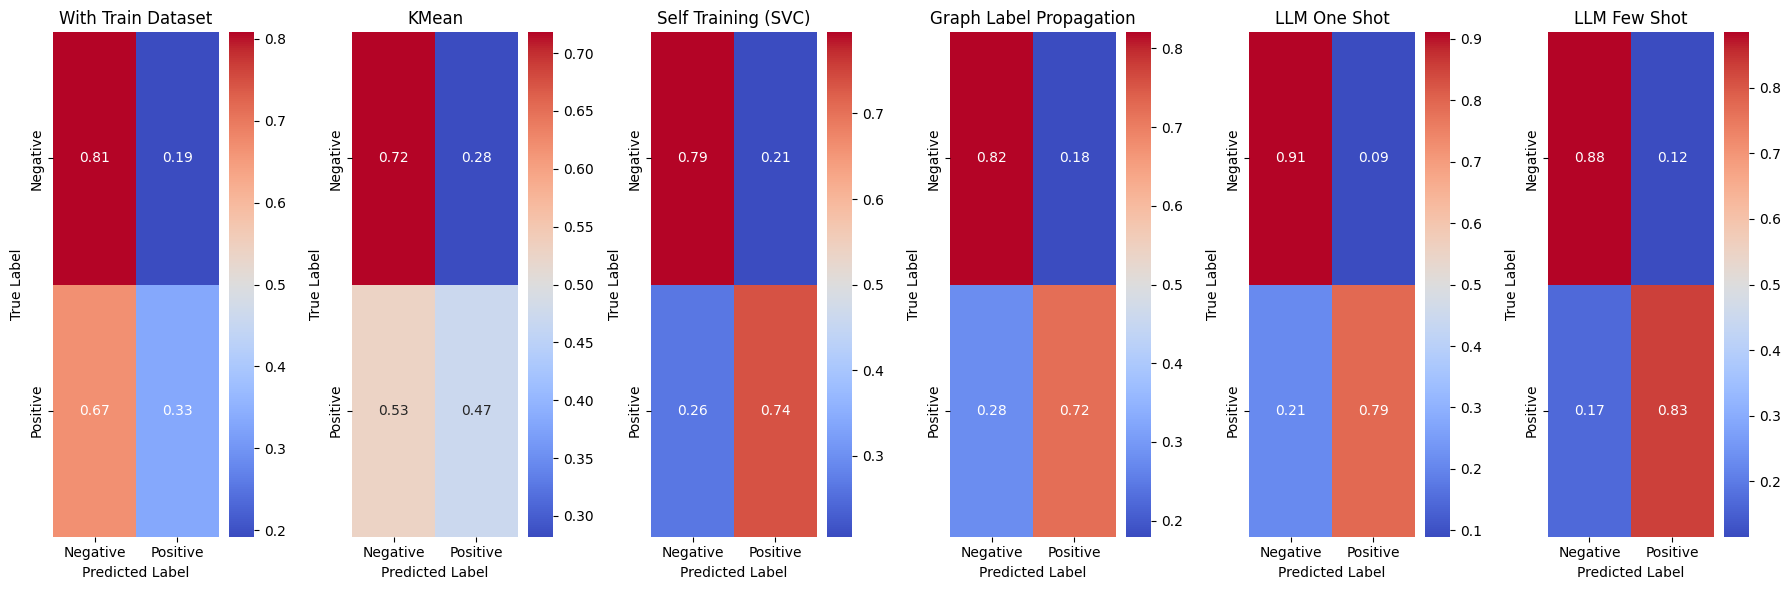

In [108]:
plot_confusion_matrices(testImdbDf['label'], [y_pred_with_train_pca, y_pred_kmean_pca, y_pred_self_training_pca, y_pred_gaph_pca, y_pred_llm_pca_one_shot, y_pred_llm_pca_few_shot],
                        ["With Train Dataset", "KMean", "Self Training (SVC)", "Graph Label Propagation", "LLM One Shot", "LLM Few Shot"])

#### Neural Network without PCA

In [96]:
y_pred_with_train_not_pca = predict_labels_using_nn(trainImdbDf_embeddings_no_pca, trainImdbDf['label'], testImdbDf_embeddings_no_pca, testImdbDf['label'])

Epoch 1/100
4/4 [==============================] - 2s 97ms/step - loss: 0.7280 - accuracy: 0.4250 - val_loss: 0.6778 - val_accuracy: 0.6000
Epoch 2/100
4/4 [==============================] - 0s 23ms/step - loss: 0.6951 - accuracy: 0.5667 - val_loss: 0.6859 - val_accuracy: 0.5333
Epoch 3/100
4/4 [==============================] - 0s 25ms/step - loss: 0.6794 - accuracy: 0.5833 - val_loss: 0.6916 - val_accuracy: 0.4667
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 0.6737 - accuracy: 0.5917 - val_loss: 0.6821 - val_accuracy: 0.5333
Epoch 5/100
4/4 [==============================] - 0s 23ms/step - loss: 0.6751 - accuracy: 0.5917 - val_loss: 0.6787 - val_accuracy: 0.5333
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 0.6706 - accuracy: 0.5500 - val_loss: 0.6726 - val_accuracy: 0.5667
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 0.6228 - accuracy: 0.6583 - val_loss: 0.6703 - val_accuracy: 0.5000
Epoch 8/100
4/4 [===

In [111]:
y_pred_kmean_not_pca = predict_labels_using_nn(X_combined_not_pca_labelled, y_combined_not_pca_labelled, testImdbDf_embeddings_no_pca, testImdbDf['label'])

Epoch 1/100
30/30 [==============================] - 4s 12ms/step - loss: 0.6357 - accuracy: 0.6133 - val_loss: 0.4778 - val_accuracy: 0.8326
Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 0.5167 - accuracy: 0.7648 - val_loss: 0.3732 - val_accuracy: 0.8884
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4420 - accuracy: 0.8206 - val_loss: 0.2575 - val_accuracy: 0.9099
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 0.3874 - accuracy: 0.8464 - val_loss: 0.2114 - val_accuracy: 0.9313
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3925 - accuracy: 0.8496 - val_loss: 0.1960 - val_accuracy: 0.9313
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3621 - accuracy: 0.8593 - val_loss: 0.2700 - val_accuracy: 0.9185
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3407 - accuracy: 0.8743 - val_loss: 0.1854 - val_accuracy: 0.9185
Epoch 8/100


In [97]:
y_pred_self_training_not_pca = predict_labels_using_nn(all_embeddings_no_pca, all_labels_self_training_not_pca, X_test_no_pca, y_test_no_pca)

Epoch 1/100
30/30 [==============================] - 2s 10ms/step - loss: 0.6790 - accuracy: 0.5875 - val_loss: 0.5806 - val_accuracy: 0.6652
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5784 - accuracy: 0.6992 - val_loss: 0.4076 - val_accuracy: 0.8970
Epoch 3/100
30/30 [==============================] - 0s 6ms/step - loss: 0.4352 - accuracy: 0.8099 - val_loss: 0.2156 - val_accuracy: 0.9528
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 0.3138 - accuracy: 0.8894 - val_loss: 0.1459 - val_accuracy: 0.9700
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 0.2225 - accuracy: 0.9184 - val_loss: 0.1070 - val_accuracy: 0.9700
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3284 - accuracy: 0.8679 - val_loss: 0.1524 - val_accuracy: 0.9356
Epoch 7/100
30/30 [==============================] - 0s 6ms/step - loss: 0.2330 - accuracy: 0.9119 - val_loss: 0.0988 - val_accuracy: 0.9742
Epoch 8/100


In [98]:
y_pred_gaph_not_pca = predict_labels_using_nn(all_embeddings_no_pca, all_labels_garph_not_pca, testImdbDf_embeddings_no_pca, testImdbDf['label'])

Epoch 1/100
30/30 [==============================] - 1s 10ms/step - loss: 0.6975 - accuracy: 0.5306 - val_loss: 0.6469 - val_accuracy: 0.6567
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6504 - accuracy: 0.6101 - val_loss: 0.5790 - val_accuracy: 0.7597
Epoch 3/100
30/30 [==============================] - 0s 6ms/step - loss: 0.6236 - accuracy: 0.6509 - val_loss: 0.5660 - val_accuracy: 0.7425
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 0.5654 - accuracy: 0.7046 - val_loss: 0.5563 - val_accuracy: 0.7382
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5463 - accuracy: 0.7143 - val_loss: 0.5064 - val_accuracy: 0.7811
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5195 - accuracy: 0.7411 - val_loss: 0.5032 - val_accuracy: 0.7682
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5260 - accuracy: 0.7530 - val_loss: 0.5175 - val_accuracy: 0.7768
Epoch 8/100


In [99]:
y_pred_llm_no_pca_one_shot = predict_labels_using_nn(all_embeddings_one_shot_not_pca, all_labels_one_shot, testImdbDf_embeddings_no_pca, testImdbDf['label'])

Epoch 1/100
29/29 [==============================] - 2s 10ms/step - loss: 0.6851 - accuracy: 0.5564 - val_loss: 0.6066 - val_accuracy: 0.7885
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.6197 - accuracy: 0.6748 - val_loss: 0.4746 - val_accuracy: 0.8282
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.5030 - accuracy: 0.7577 - val_loss: 0.3744 - val_accuracy: 0.8238
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 0.4102 - accuracy: 0.8274 - val_loss: 0.3171 - val_accuracy: 0.8546
Epoch 5/100
29/29 [==============================] - 0s 9ms/step - loss: 0.3693 - accuracy: 0.8440 - val_loss: 0.2854 - val_accuracy: 0.8899
Epoch 6/100
29/29 [==============================] - 0s 10ms/step - loss: 0.3675 - accuracy: 0.8507 - val_loss: 0.2852 - val_accuracy: 0.8987
Epoch 7/100
29/29 [==============================] - 0s 8ms/step - loss: 0.3398 - accuracy: 0.8562 - val_loss: 0.2936 - val_accuracy: 0.8767
Epoch 8/100

In [100]:
y_pred_llm_no_pca_few_shot = predict_labels_using_nn(all_embeddings_few_shot_not_pca, all_labels_few_shot, testImdbDf_embeddings_no_pca, testImdbDf['label'])

Epoch 1/100
27/27 [==============================] - 2s 12ms/step - loss: 0.7023 - accuracy: 0.5198 - val_loss: 0.6580 - val_accuracy: 0.7943
Epoch 2/100
27/27 [==============================] - 0s 5ms/step - loss: 0.6683 - accuracy: 0.5880 - val_loss: 0.5919 - val_accuracy: 0.8565
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 0.5929 - accuracy: 0.6994 - val_loss: 0.4488 - val_accuracy: 0.8565
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.4970 - accuracy: 0.7641 - val_loss: 0.3656 - val_accuracy: 0.8756
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 0.4220 - accuracy: 0.8240 - val_loss: 0.3055 - val_accuracy: 0.8900
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 0.3746 - accuracy: 0.8407 - val_loss: 0.2889 - val_accuracy: 0.8756
Epoch 7/100
27/27 [==============================] - 0s 5ms/step - loss: 0.3713 - accuracy: 0.8491 - val_loss: 0.2911 - val_accuracy: 0.8947
Epoch 8/100


The results when using PCA and without PCA are almost the same. The accuracy is higher when using the unlabelled data that is labelled by the LLM model using few shot learning compared to the other labelling methods.

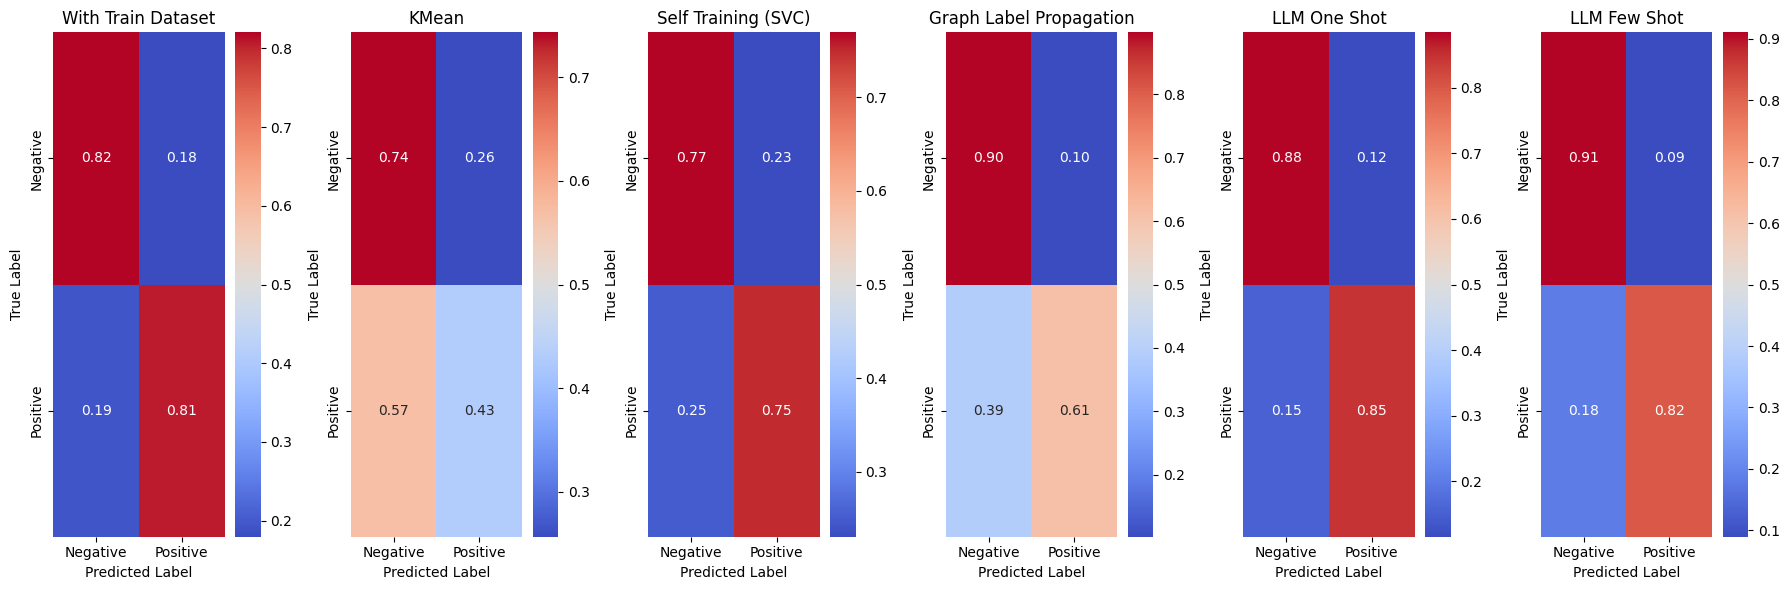

In [112]:
plot_confusion_matrices(testImdbDf['label'], [y_pred_with_train_not_pca, y_pred_kmean_not_pca, y_pred_self_training_not_pca, y_pred_gaph_not_pca, y_pred_llm_no_pca_one_shot, y_pred_llm_no_pca_few_shot],
                        ["With Train Dataset", "KMean", "Self Training (SVC)", "Graph Label Propagation", "LLM One Shot", "LLM Few Shot"])

# Questions

`Questoin 1: Research semi-supervised problems and explain how to select a proportion of data for manual labeling. Does the choice of data matter? `  
Here we list some of the challenges in semi-supervised learning:
1. **Data Quality**:  
Noisy Unlabeled Data: Unlabeled data can contain errors, inconsistencies, or outliers. These can mislead the model and hinder its ability to learn accurate patterns. Techniques like data cleaning or outlier detection might be necessary.  
Distribution Shift: The unlabeled data might not perfectly represent the real-world distribution the model will encounter. This can lead to the model performing well on the training data but generalizing poorly to new data.  
2. **Labeling Uncertainty**:  
Confidence Threshold: When using predicted labels from unlabeled data, setting a high confidence threshold can discard potentially valuable information. Conversely, a low threshold might include noisy predictions. Finding the right balance is crucial.
3. **Model Complexity**:  
Overfitting to Labeled Data: The model might focus too heavily on the limited labeled data, neglecting the valuable information in the unlabeled data. Techniques like regularization can help mitigate this.
Choice of Base Classifier: The performance of semi-supervised learning hinges on the effectiveness of the chosen base classifier (SelfTrainingClassifier's internal classifier). A weak base classifier might not learn well from the unlabeled data
selection of the proportion of data for manual labeling is a crucial step in semi-supervised learning. The choice of data matters because it can significantly impact the model's performance.


Unfortunately, there's no one-size-fits-all answer to the ideal proportion of labeled data for semi-supervised learning. It depends on several factors:  
1. **Complexity of the Task**: More intricate tasks often require a higher percentage of labeled data to provide clear guidance for the model  
2. **Size of Unlabeled Data**: With a massive unlabeled dataset, you might get away with a smaller percentage of labeled data. However, a smaller unlabeled dataset may necessitate a larger labeled proportion.
3. **Desired Model Performance**: For mission-critical applications, a higher labeled data percentage might be necessary to ensure accuracy and reliability.
A general guideline is to monitor the model's performance as you label more data. If the model's performance plateaus, it might be time to stop labeling more data. Conversely, if the model's performance continues to improve, consider labeling more data to further enhance the model's learning. So we should start with a small percentage (5-10%) and evaluate the model's performance on a validation set, Gradually increase the labeled data proportion and observe how model accuracy improves. There's a point where adding more labeled data yields diminishing returns (diminishing marginal utility) and stop when the improvement plateaus.   

Choosing the right data points for manual labeling significantly impacts the effectiveness of semi-supervised learning. Here are some strategies for selecting data:  
1. **Informativeness**: Prioritize data points that are most informative for the model. These could be:
    - Representative: Samples that capture the overall distribution of the unlabeled data.
    - Boundary Examples: Data points near decision boundaries to help the model distinguish between classes better.
    - Active Learning: Use uncertainty sampling techniques to select data points where the model is most uncertain.
2. **Diversity**: Choose data points that cover a wide range of possible features and values within the unlabeled data. Avoid redundancy.
3. **Cost-Effectiveness**: Consider the cost of labeling certain data points. Sometimes, simpler examples might be more efficient for conveying the desired information.


`Question 2: For label propagation, how many data points did you label using your manually labeled data? Explain the trade-off between quality and quantity of your labeled data.`  
We used the methods self-training with SVC, KMeans clustering, and label propagation to label the data and we label all unlabelled data that we had. The trade-off between quality and quantity of labeled data is a crucial consideration in semi-supervised learning. Here are some key points to consider:
1. **Quality**:
    - High-quality labels are essential for training accurate models. Noisy or incorrect labels can mislead the model and reduce its
    - Quality labels can be obtained through manual labeling, expert knowledge, or high-confidence predictions from the model.
    - The quality of labeled data can significantly impact the model's performance. It's better to have a smaller amount of high-quality labeled data than a larger amount of noisy or incorrect labels.
2. **Quantity**:
    - More labeled data can help the model learn better patterns and generalize well to unseen data.
    - However, labeling data can be time-consuming and expensive. It's essential to balance the cost of labeling with the benefits it provides.
    - In some cases, a smaller amount of high-quality labeled data might be sufficient to train an accurate model, especially when combined with a large amount of unlabeled data.
3. **Trade-off**:
    - The trade-off between quality and quantity of labeled data depends on the specific task, dataset, and resources available.
    - In general, it's better to start with a smaller amount of high-quality labeled data and gradually increase the quantity as needed.
    - Monitoring the model's performance on a validation set can help determine when to stop labeling more data.
    - The goal is to find the right balance between quality and quantity of labeled data to train an accurate and reliable model.

In LLM part we first label all unlabelled data but then we let the model to predict the labels for the unlabelled data, we assign -1 as the label for the labels that sentiments that does not contain negative or positive word. By using one shot example we labeled 981 data and also we labeled 894 by using few shot examples (giving 3 positive and 3v negative reviews). So in this part we reduce the quantity in order to have our desired quality.

`Question 3: Research the limitations of label propagation methods. Can these limitations be overcome using a large language model (LLM)? If yes, explain how and why using LLMs is more effective for these tasks`  
1. **Scalability**:
- Limitation: Label propagation methods often involve constructing a graph where nodes represent data points and edges represent similarities. For large datasets, this graph can become extremely large, making the computation of label propagation inefficient and resource-intensive.
- LLM Solution: Large language models (LLMs) can process text data without explicitly constructing a similarity graph, thereby reducing the computational complexity associated with large-scale datasets. LLMs can infer relationships and patterns directly from the data using their pretrained knowledge.

2. **Noise Sensitivity**:
- Limitation: Label propagation methods are sensitive to noisy data. If the initial set of labeled data contains errors, these errors can propagate throughout the dataset, leading to poor performance.
- LLM Solution: LLMs, particularly those fine-tuned on high-quality datasets, have shown robustness to noise. Their training on large, diverse datasets allows them to generalize better and mitigate the impact of noisy labels by leveraging context and broader patterns in the data.  

3. **Graph Construction**:
- Limitation: The effectiveness of label propagation heavily relies on the quality of the similarity graph. Constructing an optimal graph requires choosing appropriate features and similarity measures, which can be challenging and domain-specific.
- LLM Solution: LLMs bypass the need for explicit feature engineering and similarity measures. They inherently capture semantic relationships and contextual information, which can lead to better performance without the need for handcrafted features or similarity metrics.

3. **Homophily Assumption**:
- Limitation: Label propagation assumes that similar nodes are likely to share the same label (homophily). This assumption may not hold in all cases, especially in heterogeneous datasets where similar data points might have different labels.
- LLM Solution: LLMs are capable of understanding complex patterns and relationships that go beyond simple similarity measures. They can capture nuanced differences and contextual dependencies, allowing them to perform well even in datasets where the homophily assumption does not hold.

`Question 4: Research the history of language modeling, their evolution, and explain how they work. Discuss the advantages and limitations of language models, especially large language models (LLMs), in various tasks.`  
- History and Evolution of Language Models:
    1. Early Language Models:  
        - n-gram Models (1950s-1990s): The earliest language models were based on n-grams, which predict the next word in a sequence based on n-grams, which predict the next word in a sequence based on the previous n−1 words. These models are simple and effective for many tasks but struggle with long-range dependencies due to their limited context window.
        - Markov Models: Markov models, including Hidden Markov Models (HMMs), were also used for language modeling, relying on the Markov property where the probability of a word depends only on a fixed number of previous words.
    2. Statistical Language Models (1990s-2000s):
        -   Stochastic Processes: Techniques such as Maximum Entropy models and various smoothing techniques were introduced to better estimate the probabilities of rare events in n-gram models.
        -   Latent Semantic Analysis (LSA): Introduced in the 1990s, LSA uses matrix factorization to capture the underlying structure of words in a large corpus, improving the handling of synonyms and polysemy.
    3. Neural Network-based Models (2010s):
        -   Recurrent Neural Networks (RNNs): In the early 2010s, RNNs, and later Long Short-Term Memory (LSTM) networks, were used to model sequences of words, allowing for better handling of long-range dependencies.
        -   Word Embeddings: Models like Word2Vec (2013) and GloVe (2014) created dense vector representations of words that capture semantic meaning based on context.
    4. Transformers and Pretrained Models (2017-present):
        -   Transformers: The introduction of the Transformer architecture in 2017 revolutionized language modeling. Transformers use self-attention mechanisms to capture dependencies across entire sequences, improving the handling of long-range relationships.
        -   Pretrained Models: BERT (2018), GPT (2018), and their successors (GPT-2, GPT-3, etc.) leveraged massive corpora and pretraining on diverse text data, followed by fine-tuning on specific tasks. These models set new benchmarks in natural language understanding and generation tasks.
        -   Large Language Models (LLMs): Models like GPT-3 and GPT-4 are examples of LLMs, containing billions of parameters and trained on vast datasets. They have demonstrated impressive capabilities in various NLP tasks, such as text generation, translation, and question-answering.
- How Language Models Work:
    Modern LMs, especially those based on Transformers, work in the following way:
    1. Tokenization: Text is broken down into smaller units called tokens (words, sub-words, or characters).
    2. Embedding: Each token is mapped to a numerical vector representation (embedding) capturing its meaning and relationships with other words.
    3. Encoder-Decoder Architecture (Transformer):
        -   Encoder: Processes the input sequence of tokens, capturing the overall context.
        -   Decoder: Generates the output sequence one token at a time, using the encoded context and previously generated tokens to predict the next word.
        -   Attention Mechanism: Allows the model to focus on specific parts of the input sequence that are most relevant for predicting the current token, leading to better understanding of long-range dependencies.
    4. Training: The model is trained on a massive dataset of text and code, where it learns to predict the next word or code token in a sequence by minimizing the difference between its prediction and the actual text.
- Advantages of Language Models:
    1. Text Generation: LLMs can generate human-quality text, from creative writing to code completion.
    2. Machine Translation: LLMs are pushing the boundaries of machine translation, providing more accurate and nuanced translations.
    3. Text Summarization: LLMs can effectively summarize large amounts of text, extracting key points and condensing information.
    4. Question Answering: LLMs can answer complex questions in an informative way, drawing from their knowledge base and understanding of context.
    5. Sentiment Analysis: LLMs can analyze the sentiment of text data, identifying positive, negative, or neutral opinions.
    6. Chatbots and Virtual Assistants: LLMs power more engaging and informative chatbots and virtual assistants, understanding natural language and providing helpful responses.
- Limitations of Language Models:
    1. Data Bias: LLMs can inherit biases present in their training data, leading to discriminatory or offensive outputs. Mitigating bias is an ongoing research challenge.
    2. Lack of Common Sense Reasoning: LLMs struggle with tasks requiring common sense reasoning or real-world understanding.
    3. Black Box Nature: The complex inner workings of LLMs can be difficult to interpret, making it challenging to understand their reasoning behind specific outputs.
    4. Computational Cost: Training and using LLMs require significant computational resources, limiting their accessibility to some users.
    5. Potential for Misinformation: The ability of LLMs to generate realistic text can be misused to create deepfakes or spread misinformation.

`Question 5: For each method (LLM/Label-Propagation), explain its advantages and disadvantages.`  
As we mentioned earlier, We used graph based label propagation, KMeans clustering, and self-training with SVC to label the unlabelled data. Here are the advantages and disadvantages of each method:
1. Large Language Models (LLMs):
    -   Advantages:
        -   High Capacity for Learning Complex Relationships: LLMs trained on massive amounts of text data can capture intricate relationships between words and concepts, leading to better understanding of data structure for labeling.
        -   Incorporation of External Knowledge: LLMs can be fine-tuned with domain-specific knowledge bases, enriching their understanding and potentially improving label propagation.
        -   Handling Noise and Ambiguity: LLMs are often trained on noisy and ambiguous text data, making them more robust to such issues in your dataset compared to simpler methods.
    -   Disadvantages:
        -   Computational Cost: Training and using LLMs require significant hardware resources, making them potentially expensive or impractical for some applications.
        -   Black Box Nature: Understanding the reasoning behind an LLM's predictions can be challenging, limiting interpretability of results.
        -   Data Bias: LLMs can inherit biases present in their training data, which can affect their label propagation if not carefully addressed.
2. Label Propagation (Graph-Based):
    -   Advantages:
        -   Simplicity and Efficiency: Label propagation is a relatively straightforward algorithm, making it easy to implement and computationally efficient.
        -   Leverages Unlabeled Data: It utilizes both labeled and unlabeled data, offering potential for improved performance compared to using only labeled data.
        -   Intuitive for Data with Smooth Transitions: For data where similar features indicate similar class labels, label propagation can be effective.
    -   Disadvantages:
        -   Smooth Assumption Limitation: It assumes data points with similar features belong to the same class, which might not hold true for complex datasets.
        -   Limited Handling of Noise: Label propagation struggles with noisy data as errors can easily propagate through the graph.
        -   Inability to Model Complex Relationships: Label propagation doesn't capture intricate relationships between features and classes that might be present in the data.
        -   Susceptibility to Imbalanced Classes: If one class dominates the labeled data, it can bias the propagation process, neglecting minority classes.
3. K-Means Clustering:
    -   Advantages:
        -   Simplicity and Interpretability: K-means is a well-known clustering algorithm, relatively easy to implement and understand.
        -   Unsupervised Learning: It doesn't require labeled data, potentially useful for exploratory analysis or pre-processing unlabeled data before using other methods.
    -   Disadvantages:
        -   Limited Semi-Supervised Capability: While it can be used with labeled data to influence cluster centers, k-means isn't specifically designed for semi-supervised learning tasks.
        -   Assumption of Spherical Clusters: It assumes data forms spherical clusters, which may not be true for all datasets.
        -   Sensitivity to Initialization: K-means results can depend on the initial placement of cluster centers, potentially leading to suboptimal solutions.
        -   No Explicit Label Propagation: K-means doesn't directly propagate labels from labeled data to unlabeled data points.
4. Self-Training:
    -   Advantages:
        -   Leverages Unlabeled Data: Self-training utilizes both labeled and unlabeled data, offering potential for improved performance compared to using only labeled data.
        -   Iterative Improvement: By iteratively training a model on labeled data and using its predictions to label unlabeled data, self-training can improve over time.
    -   Disadvantages:
        -   Risk of Error Propagation: If the base classifier makes mistakes, those errors can be propagated to the unlabeled data, potentially worsening performance.
        -   Selection Strategy Crucial: The method of selecting unlabeled data for labeling can significantly impact the effectiveness of self-training.
        -   Potential for Overfitting: Self-training can lead the model to overfit to the labeled data, neglecting valuable information in the unlabeled data.
        -   Computational Cost: Training a model iteratively can be computationally expensive, especially for large datasets.

`Question 6: Certainly, you have worked with large language models (LLMs) since they were made public, and you might even be using one right now to help you with your assignment! How has your experience been while interacting with one of them? How do other LLMs differ from each other? Name some of these LLMs that you have worked with and share your opinion about them.`  
Our experience with different LLMs indicates that a good prompt may be different to get the best results from different LLMs. Also in our experience they do not work properly when giving them complex tasks; In this case we should break down the task into small understandable and easier tasks. Also if we explain the task step by step we can get better results.  

- How LLMs differ:
    -   Training Data and Architecture: Different LLMs are trained on varying datasets and use diverse architectures (like transformers or recurrent neural networks). This can lead to differences in their strengths and weaknesses. Some might excel at factual language tasks, while others might be better at creative text generation.
    -   Focus and Fine-tuning: Some LLMs are fine-tuned for specific tasks, like machine translation or question answering. This specialization can make them more effective in those domains.
    -   Accessibility and Transparency: Some LLMs are open-source and allow for exploration and experimentation, while others are commercially available with limited access to their inner workings.

Chat GPT, Gemini, Hugging Chat and Copilot are some of the tools that we used which use LLMs to generate text. We found that Chat GPT is better for generating text and answering questions, while Gemini is better for generating code. Hugging Chat is a good tool for generating text and code, and Copilot is good for generating code and providing suggestions. 